##Desafío - Análisis lineal discriminante

##Requerimientos
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta seregistran las siguientes observaciones:
● default: Variable Binaria. Registra si el cliente entró en morosidad o no.
● income: Ingreso promedio declarado por el cliente.
● balance: total del saldo en la cuenta de crédito.
● student: Variable binaria. Registra si el cliente es estudiante o no.


##Ejercicio 1: Preparación de ambiente de trabajo
● Importe los módulos básicos para el análisis de datos.
● Importe las clases LabelEncoder, StandardScaler y LabelBinarizer de preprocessing.
● Importe las funciones train_test_split y cross_val_score de model_selection.
● Importe la función classification_report de metrics.
● Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis.
● Agregue la base de datos en el ambiente de trabajo.
● Inspeccione la distribución de cada atributo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
#para transformar los objects string a atributos numéricos importamos LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


import sys
#sys.path.append('../../')
import lec4_graphs as gfx
import lec3_graphs as afx
import classmodelsdiag as cmd
plt.style.use('ggplot')

##Análisis exploratorio del data set

In [2]:
# botamos la columna de index
df = pd.read_csv('default_credit.csv').drop(columns='index')

print(df.head())

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


In [3]:
df.sample()

,default,student,balance,income
6996,No,No,765.233878,29096.417261


In [4]:
df = df.rename(columns={'default':'morosidad'})

In [5]:
df.shape

(10000, 4)

In [6]:
df.sample()

,morosidad,student,balance,income
5704,No,No,419.729052,37444.536061


In [7]:
# guardamos las etiquetas de cada clase para posterior uso.
target_label = df['morosidad'].unique()

In [8]:
df

,morosidad,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [9]:
df['morosidad'] = LabelEncoder().fit_transform(df['morosidad']) #Transformamos a numéricos
df['student'] = LabelEncoder().fit_transform(df['student']) #Transformamos a numéricos

In [27]:
df.head()

,morosidad,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


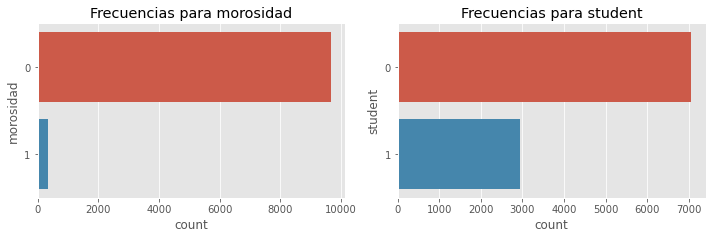

In [10]:
#Veamos como se comportan cada uno de estos atributos 
plt.figure(figsize=(10, 6))
for n, i in enumerate(['morosidad','student']):
    plt.subplot(2, 2, n + 1)
    sns.countplot(y= df[i], order= df[i].value_counts().index)
    plt.title('Frecuencias para {}'.format(i))
    plt.tight_layout()

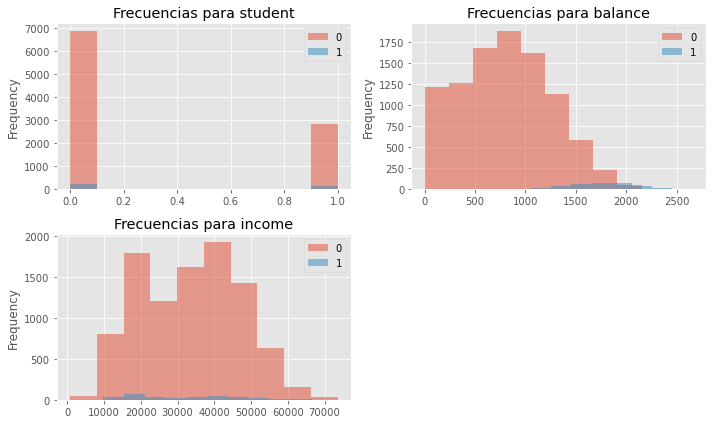

In [11]:
#Veamos como se comportan cada uno de estos atributos
plt.figure(figsize=(10, 6))
#Excluimos temporalmente nuestro vector objetivo
for n, i in enumerate(df.drop(columns = {'morosidad'}).columns):
    plt.subplot(2, 2, n + 1)
    df.groupby('morosidad')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['morosidad'].unique())
    plt.title('Frecuencias para {}'.format(i))
    plt.tight_layout()

Según el gráfico de student, podemos notar que para no estudiante hay un mayor indice de no morosidad.
Mientras que en el balance podemos ver que las personas que presentan saldos de crédito entre 1000 y 2500 son las que tienen un mayor riesgo de morosidad. Sin embargo con el income se dificulta ver la relación con la morosidad debido a que las clases estan muy solapadas y los rangos entre estas son muy distintos.


##Implementación del algoritmo

El siguiente paso es generar una instancia del clasificador. La documentación hace a una
serie de hiperparámetros, de los cuales consideramos tres como relevantes:
1. priors: Permite ingresar la probabilidad a priori para cada clase en el algoritmo de
entrenamiento. Éstos deben ser ingresados como una lista especificando la
probabilidad entre 0 y 1 para cada clase. Por defecto es None. Pueden referirse a la
lectura de Bayes Ingenuo para ver algunos enfoques sobre las probabilidades a
priori.
2. tol: Criterio de tolerancia para la decomposición de valores singulares. Por lo
general este no suele modificarse, salvo en contadas ocasiones. Una de ellas es
cuando el algoritmo no alcance la decomposición, para lo cual se podría disminuir el
umbral de tolerancia para analizar soluciones tentativas. Un punto a destacar es que
la tolerancia por defecto 1. 0𝑒 − 4 ya es relativamente baja, en comparación a los
umbrales de tolerancia en otros métodos de solución como la máxima verosimilitud
(donde por defecto se asume que es 1. 0𝑒 − 6.
3. n_components: Cantidad de discriminantes lineales a estimar. Por defecto el método
estima que el número de discriminantes lineales a estimar es 1 − 𝑁𝑌

Existen otros hiperparámetros como el método de solución (solver) que recomendamos no
modificar sin motivos de peso.
Nuestro primer modelo tomará los argumentos por defecto. Partimos por instanciar un
objeto y posteriormente implementar el método .fit donde ingresamos nuestra matriz de
atributos y vector objetivo.


##Ejercicio 2: Modelo base
● Recuerde que los modelos de sklearn no soportan datos que no sean numéricos.
Transforme los atributos pertinentes con LabelEncoder.
● Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
● Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiper
parámetros. Genere métricas de evaluación utilizando classification_report.
● Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [12]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df.loc[:, 'morosidad':'income'], df['morosidad'], test_size=.33, random_state=11238)

In [13]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis()

In [14]:
lda_model = LinearDiscriminantAnalysis(n_components=1, priors=None,
            shrinkage=None,solver='svd', store_covariance=False, tol=0.0001)

lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis(n_components=1)

In [15]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.96731343 0.03268657] 

Medias de atributos en cada clase
 [[0.000000e+00 2.900000e-01 8.036500e+02 3.340200e+04]
 [1.000000e+00 3.600000e-01 1.734750e+03 3.217489e+04]] 

Varianza explicada por cada discriminante
 [1.] 



In [16]:
#Los coeficientes nos van a informar acerca de la combinación lineal de parámetros que se implementaron para 
#generar las fronteras de decisión
lda_model.coef_

array([[-0.00000000e+00, -6.46927932e-01,  4.65931873e-03,
        -7.50785395e-07]])

In [17]:
#Vamos a guardar las predicciones de clase
lda_class_pred = lda_model.predict(X_test_mat)
#Extraemos las clases predichas
lda_class_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#Diagnóstico de ALD

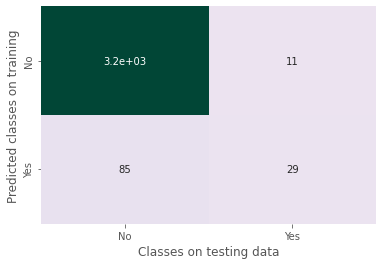

In [18]:
gfx.plot_confusion_matrix(y_test_vec, lda_class_pred, classes_labels=target_label)
#El modelo no clasifica correctamente todas las observaciones

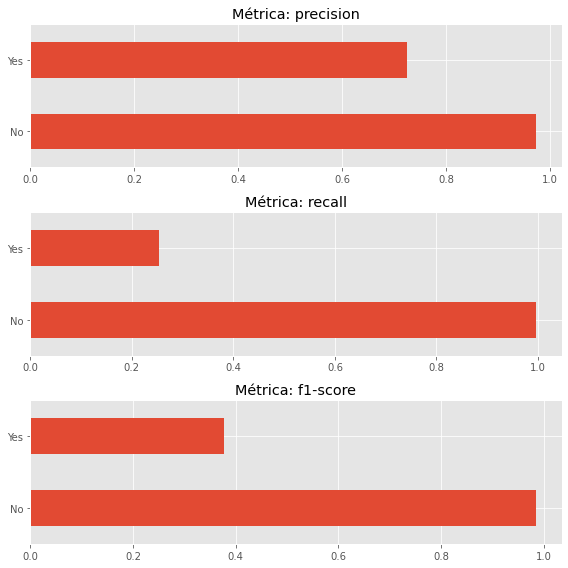

In [19]:
plt.figure(figsize=(8, 8))
#Con plt_class_report podemos sintetizar la información que viene en la función clasification report de una manera
#muchoo mas amigable
gfx.plot_class_report(y_test_vec, lda_class_pred, classes_labels=target_label)

In [20]:
from sklearn.metrics import classification_report
# generar un reporte de métricas de precisión, recall y f1
print(classification_report(y_test_vec, lda_class_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3186
           1       0.72      0.25      0.38       114

    accuracy                           0.97      3300
   macro avg       0.85      0.63      0.68      3300
weighted avg       0.97      0.97      0.96      3300



In [21]:
#Aqui podemos ver que la precision para 0 es bastante alta, es decir, que predice bien para quienes no tienen morosidad.
#El accuracy es bastante alto lo cual nos indica que predice con bastante certeza el modelo

Ejercicio 3: Refactorización 1 - información a priori
● Dado que trabajamos con modelos generativos, podemos incluir información
exógena. Para este caso agregaremos dos distribuciones:
○ Asumamos que hay un 50/50 de morosos y no morosos.
○ Asumamos que hay un 60/40 de morosos y no morosos.
● Por cada modelo, reporte las métricas de clasificación.

In [22]:
afx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[0.5,0.5])

A priori: [0.5, 0.5]
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
AUC: 1.0



In [23]:
print(classification_report(y_test_vec, lda_class_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3186
           1       0.72      0.25      0.38       114

    accuracy                           0.97      3300
   macro avg       0.85      0.63      0.68      3300
weighted avg       0.97      0.97      0.96      3300



In [24]:
afx.compare_priors(X_train=X_train_mat,
                   X_test=X_test_mat,
                   y_train=y_train_vec,
                   y_test=y_test_vec,
                   prior=[0.6,0.4])

A priori: [0.6, 0.4]
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
AUC: 1.0



In [25]:
print(classification_report(y_test_vec, lda_class_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3186
           1       0.72      0.25      0.38       114

    accuracy                           0.97      3300
   macro avg       0.85      0.63      0.68      3300
weighted avg       0.97      0.97      0.96      3300



En la Refactorización obtuvimos los mismos resultados que en el modelo original, lo cual puede significar que independientemente de la separación que hagamos obtendremos los mismos resultados en la predicción. No se si esto sea favorable en nuestro modelo.

##Ejercicio 4: Refactorización 2 - oversampling

Digresión: Synthetic Over(Under)Sampling
● Por lo general podemos intentar aliviar el problema del desbalance de clases
mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con
reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se
conocen como Oversampling cuando repetimos registros aleatorios de la clase
minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
● Un contratiempo de estos métodos clásicos es que pueden replicar información
sesgada que afecte el desempeño de generalización del modelo. Si los datos son
malos, estaremos replicando estas fallas.
● Otra solución es generar ejemplos de entrenamiento sintéticos mediante el
entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución
funciona de la siguiente forma: En función a un subconjunto de datos
correspondientes a la clase minoritaria, entrenamos algún modelo no supervisado o
generativo como Naive Bayes, KMeans o KNearestNeighbors para generar
representaciones sintéticas de los datos en el espacio de atributos de la clase
específica mediante 𝑥 es un ejemplo de 𝑛𝑢𝑒𝑣𝑜−𝑒𝑗𝑒𝑚𝑝𝑙𝑜 = 𝑥𝑖 + λ(𝑥𝑧𝑖 − 𝑥𝑖)
entrenamiento de la clase minoritaria y λ es un parámetro de interpolación aleatorio λ ∼ 𝑈𝑛𝑖𝑓𝑜𝑟𝑚𝑒(0, 1).
Uno de los problemas más graves de esta base de datos, es el fuerte desbalance
entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE
(Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete
a nuestro ambiente virtual. En nuestro terminal agregamos conda install -c
conda-forge imbalanced-learn. Incorpore SMOTE en el ambiente de trabajo con
la siguiente sintáxis from imblearn.over_sampling import SMOTE.
● Para implementar oversampling, debemos generar nuevos objetos que representan
nuestra muestra de entrenamiento incrementada artificialmente. Para ello
implemente la siguiente sintaxis:

Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente
sobre su desempeño.

In [31]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, sampling_strategy=0.6)
# generamos el oversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train_mat, y_train_vec)

In [32]:
#Generamos el modelo
l_model_oversample = LinearDiscriminantAnalysis()
l_model_oversample.fit(X_train_oversamp, y_train_oversamp)

LinearDiscriminantAnalysis()

In [33]:
#Guardamos las clases a predecir
l_class_pred_oversample = l_model_oversample.predict(X_test_mat)
#extraemmos las clases predichas
l_class_pred_oversample[:20]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

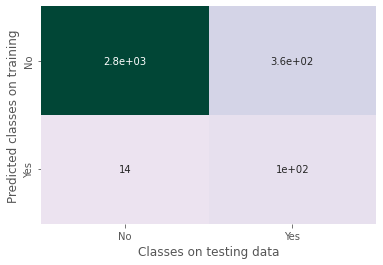

In [34]:
#Generaremos una matriz de confusión para ver el comportamiento de la predicción de nuestro modelo:
gfx.plot_confusion_matrix(y_test_vec, l_class_pred_oversample, classes_labels=target_label)

In [ ]:
#Al parecer este modelo predice de mejor manera ambas clases
#Veamos otro gráfico

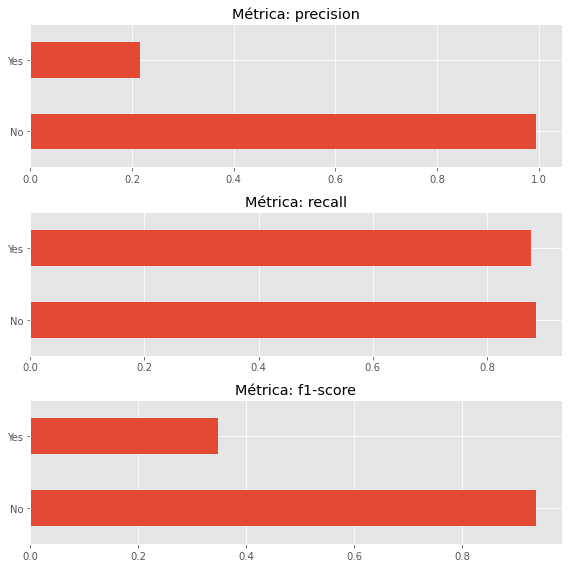

In [35]:
plt.figure(figsize=(8, 8))
gfx.plot_class_report(y_test_vec, l_class_pred_oversample, classes_labels=target_label)
#Aqui podemos ver que el modelo mejor la aclase yes en recall, pero en precisión y score desmejora.

In [36]:
#Veamos el reporte de métricas
print(classification_report(y_test_vec, l_class_pred_oversample))
#Creo que el modelo anterior estaba mejor 

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3186
           1       0.22      0.88      0.35       114

    accuracy                           0.89      3300
   macro avg       0.61      0.88      0.64      3300
weighted avg       0.97      0.89      0.92      3300



#Ejercicio 5: Refactorización 3 - QDA
● Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos
aumentados artificialmente. Genere las métricas de desempeño.
● Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#Instanciamos nuestro objeto
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_mat, y_train_vec)
#Extraemos directamente las predicciones
qda_class_pred = qda_model.predict(X_test_mat)

C:\Users\arlen\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:912: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:912: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:915: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


In [ ]:
#No entiendo este error, me dice que las variables son colineales.
#Quizas por eso se me anula "yes" en los graficos 
#No se profe, ayudita!!!

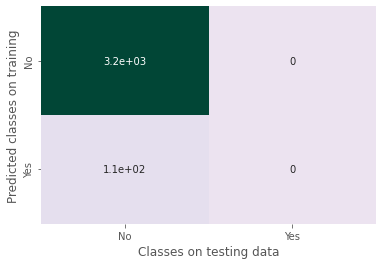

In [40]:
#Veamos como se comporta este modelo respecto a la matriz de confusión
gfx.plot_confusion_matrix(y_test_vec, qda_class_pred,
classes_labels=target_label)

C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


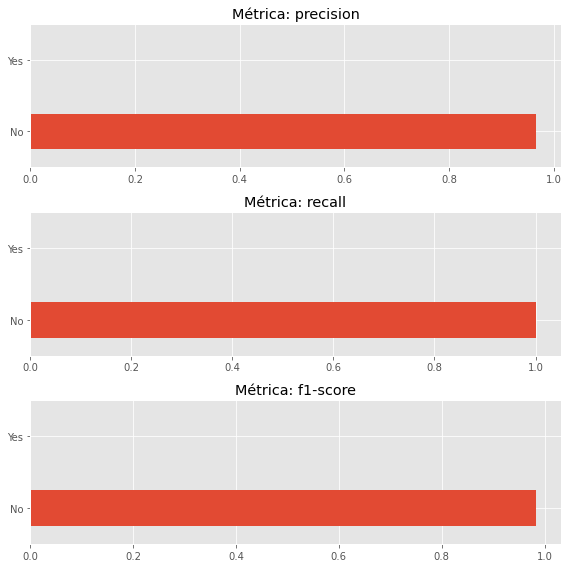

In [41]:
plt.figure(figsize=(8, 8))
gfx.plot_class_report(y_test_vec,qda_class_pred, classes_labels=target_label)

In [42]:
# generaré un reporte de métricas
print(classification_report(y_test_vec, qda_predict_oversample))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3186
           1       0.00      0.00      0.00       114

    accuracy                           0.97      3300
   macro avg       0.48      0.50      0.49      3300
weighted avg       0.93      0.97      0.95      3300



C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arlen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
